# Github Repository

### https://github.com/aminnademi/Clustring-On-North-of-Iran-Climate-Dataset

# Imports The Required Libraries

In [113]:
import pandas as pd
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from minisom import MiniSom
from sklearn.metrics import silhouette_score

# Load GRIB File & Convert It To CSV File

In [42]:
# Load the GRIB file and filter by edition
file_path = "data.grib"
ds = xr.open_dataset(
    file_path,
    engine="cfgrib",
    backend_kwargs={
        "filter_by_keys": {"edition": 1}
    }
)

# Loading "tp" feature separately due to potential mismatches with other variables in the dataset.
ds_tp = xr.open_dataset(
    file_path,
    engine="cfgrib",
    backend_kwargs={
        'filter_by_keys': {'shortName': 'tp'},
    }
)

skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\cfgrib\dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\cfgrib\dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1672531200, 1672534800, 1672538400, ..., 1735678800, 1735682400,
       1735686000])) new_value=Variable(dimensions=('time',), data=array([1672509600, 1672552800, 1672596000, ..., 1735581600, 1735624800,
       1735668000]))
skipping variable: paramId==176 shortName='ssr'
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\cfgrib\dataset.py", line 725, in build_dataset_components
    dict_

In [43]:
# Convert to DataFrame
df = ds.to_dataframe().reset_index()

# Save to CSV
csv_file = "main_data.csv"
df.to_csv(csv_file, index=False)

In [44]:
# Convert to DataFrame
df_tp = ds_tp.to_dataframe().reset_index()

# Save to CSV
df_tp.to_csv("tp_data.csv", index=False)

# Load Dataset

In [120]:
data = pd.read_csv('main_data.csv')
data_tp = pd.read_csv('tp_data.csv')

In [121]:
merged = pd.merge(data, data_tp[['longitude', 'latitude', 'time', 'tp']],
                        on=['longitude', 'latitude', 'time'],
                        how='right')

In [122]:
merged.head()

,time,latitude,longitude,number,step,surface,valid_time,t2m,msl,tcc,tp
0,2022-12-31 18:00:00,36.722,50.435000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-31 18:00:00,36.722,50.685071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-12-31 18:00:00,36.722,50.935143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-12-31 18:00:00,36.722,51.185214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-12-31 18:00:00,36.722,51.435286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
merged.shape

(526680, 11)

In [124]:
merged.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,526680.0,36.596500,0.125500,36.47100,36.471000,36.596500,36.722000,36.722000
longitude,526680.0,52.185500,1.080433,50.43500,51.185214,52.185500,53.185786,53.936000
number,526320.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
surface,526320.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
t2m,526320.0,288.370703,8.113173,256.21533,282.801695,288.834350,294.792237,307.570800
msl,526320.0,101647.236056,674.888552,99684.23400,101181.597500,101570.060000,102053.668000,104130.760000
tcc,526320.0,0.445322,0.366285,0.00000,0.068721,0.391671,0.811842,1.000007
tp,526320.0,0.000122,0.000362,0.00000,0.000000,0.000002,0.000069,0.014742


In [125]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526680 entries, 0 to 526679
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        526680 non-null  object 
 1   latitude    526680 non-null  float64
 2   longitude   526680 non-null  float64
 3   number      526320 non-null  float64
 4   step        526320 non-null  object 
 5   surface     526320 non-null  float64
 6   valid_time  526320 non-null  object 
 7   t2m         526320 non-null  float64
 8   msl         526320 non-null  float64
 9   tcc         526320 non-null  float64
 10  tp          526320 non-null  float64
dtypes: float64(8), object(3)
memory usage: 44.2+ MB


# EDA & Data Preprocessing

### Handling Missing Values

time            0
latitude        0
longitude       0
number        360
step          360
surface       360
valid_time    360
t2m           360
msl           360
tcc           360
tp            360
dtype: int64

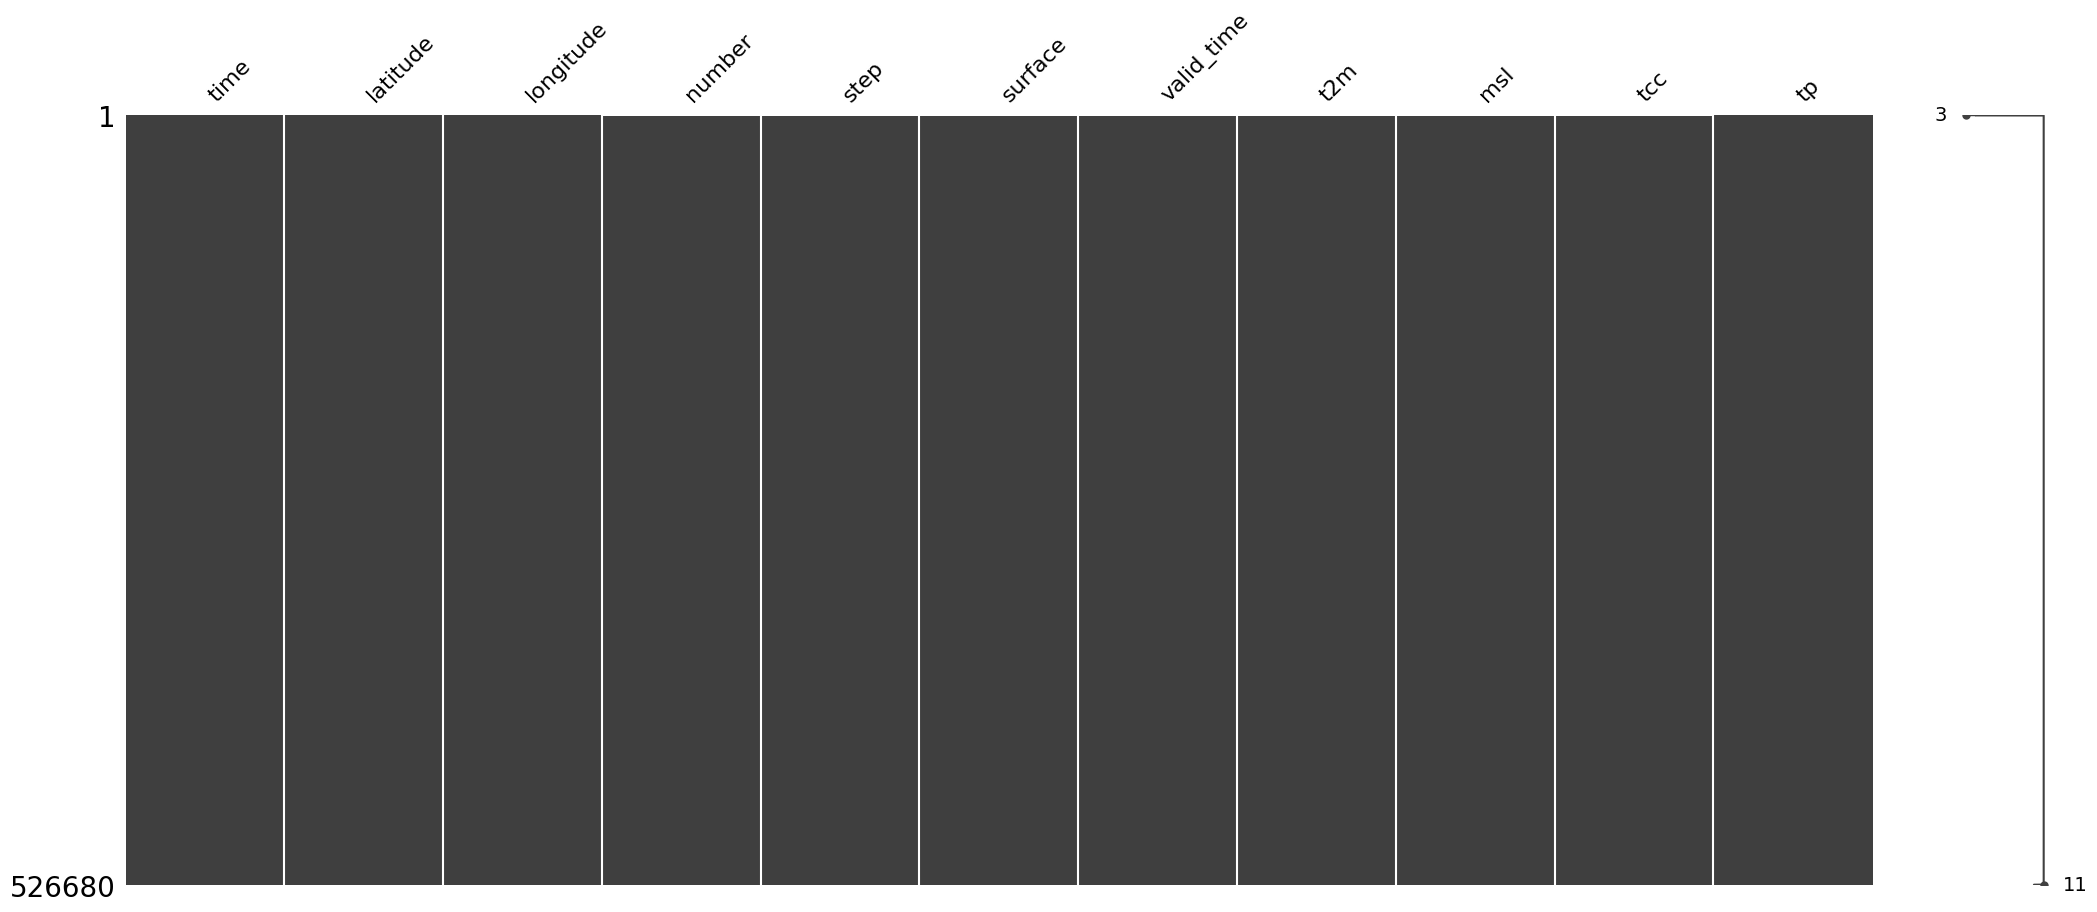

In [126]:
# Visualize missing data in the dataset using a matrix plot
msno.matrix(merged) 
# Check for missing values
merged.isnull().sum()

In [127]:
cleaned = merged.dropna()
cleaned.reset_index
cleaned.shape

(526110, 11)

### Handling Outliers

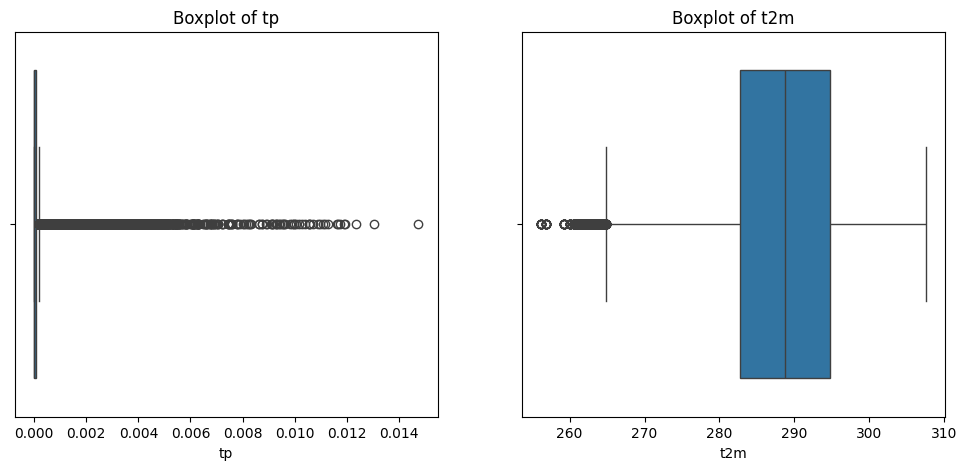

In [128]:
# Boxplot for tp and t2m
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=cleaned['tp'])
plt.title('Boxplot of tp')

plt.subplot(1, 2, 2)
sns.boxplot(x=cleaned['t2m'])
plt.title('Boxplot of t2m')

plt.show()

In [132]:
((cleaned['t2m'] >= 200) & (cleaned['t2m'] <= 270)).sum().item()

9034

In [138]:
((cleaned['tp'] >= 0.001) & (cleaned['tp'] <= 0.014)).sum().item()

14924

In [150]:
mask1 = (cleaned['t2m'] < 260) | (cleaned['t2m'] > 270)
mask2 = (cleaned['tp'] < 0.001) | (cleaned['tp'] > 0.014)

# Filter the dataset using the mask
filtered = cleaned.where(mask1)
filtered = cleaned.where(mask2)

features = filtered[['tp', 't2m']]

### Plotting

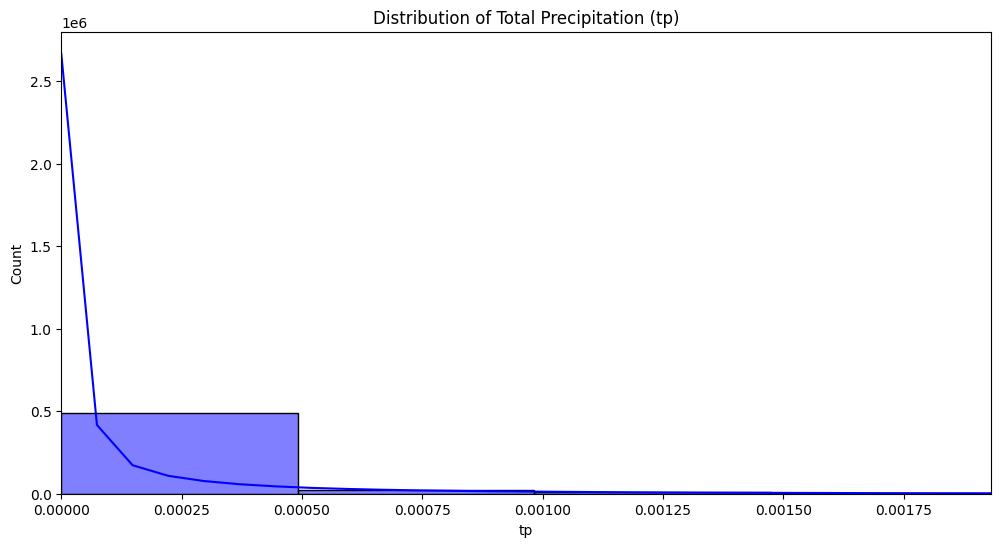

In [94]:
# Calculate mean and standard deviation
mean_tp = features['tp'].mean()
std_tp = features['tp'].std()

# Define the range for the histogram (mean ± 3 standard deviations)
lower_bound = max(mean_tp - 5 * std_tp, 0)  # Ensure lower bound is not negative
upper_bound = mean_tp + 5 * std_tp

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(features['tp'], kde=True, bins=30, color='blue')
plt.xlim(lower_bound, upper_bound)  # Set the x-axis limits
plt.title('Distribution of Total Precipitation (tp)')
plt.show()


Text(0.5, 1.0, 'Distribution of Temperature (t2m)')

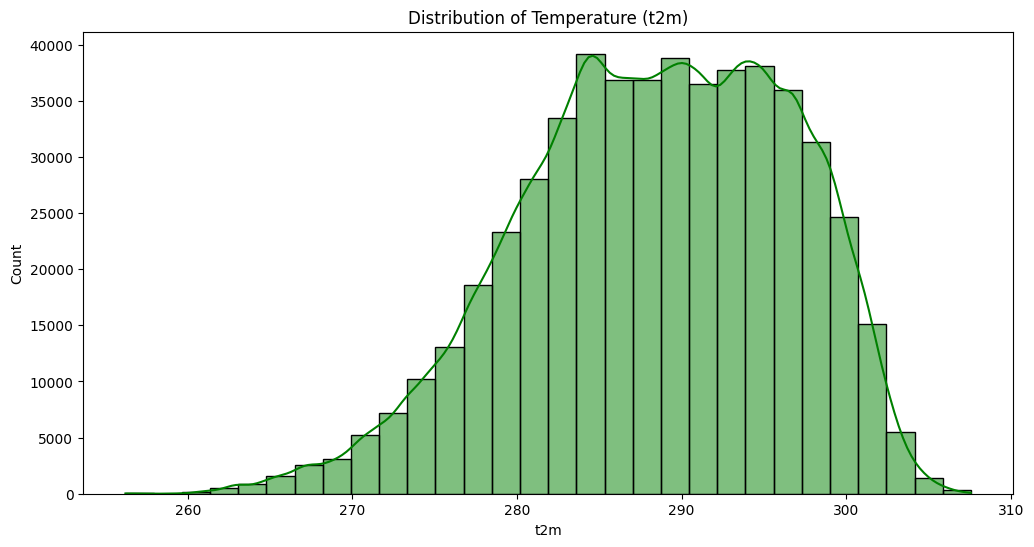

In [95]:
plt.figure(figsize=(12, 6))
sns.histplot(features['t2m'], kde=True, bins=30, color='green')
plt.title('Distribution of Temperature (t2m)')

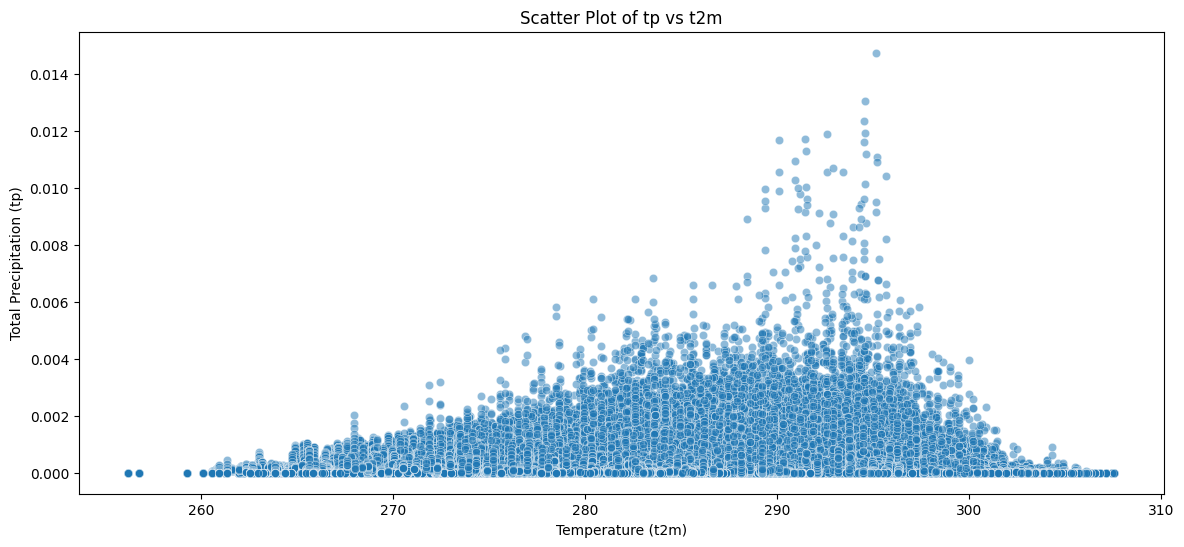

In [96]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x='t2m', y='tp', data=features, alpha=0.5)
plt.title('Scatter Plot of tp vs t2m')
plt.xlabel('Temperature (t2m)')
plt.ylabel('Total Precipitation (tp)')
plt.show()


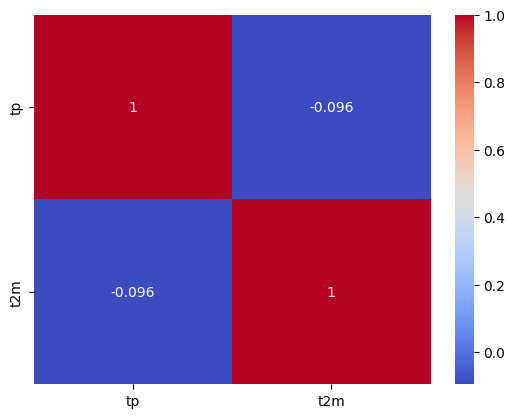

In [151]:
sns.heatmap(features.corr(), annot=True, cmap= "coolwarm")
plt.show()

In [153]:
# Calculate Spearman correlation
spearman_corr = features[['tp', 't2m']].corr(method='spearman').iloc[0, 1]
print(f"Spearman Correlation: {spearman_corr:.3f}")

Spearman Correlation: -0.016


# Feature Engineering & Applying PCA

In [98]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)  # Reduce to 2 components
pca_features = pca.fit_transform(scaled_features)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance by PCA: {explained_variance:.2f}")

Explained Variance by PCA: 1.00


# Clustering

### Funtions For Enhance The Clustring Methods

In [101]:
# Function to calculate WCSS for Agglomerative Clustering
def calculate_wcss(data, labels):
    wcss = 0
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = data[labels == label]
        cluster_center = np.mean(cluster_points, axis=0)
        wcss += np.sum((cluster_points - cluster_center) ** 2)
    return wcss

# Function to calculate quantization error for SOM
def calculate_quantization_error(som, data):
    quantization_error = 0
    for x in data:
        winner = som.winner(x)  # Find the winning neuron for each data point
        quantization_error += np.linalg.norm(x - som.get_weights()[winner])
    return quantization_error / len(data)

### Kmeans Clustring

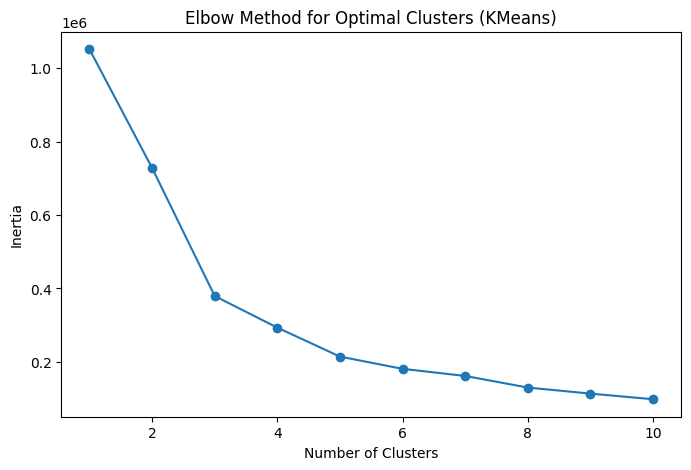

In [102]:
# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters (KMeans)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [103]:
# Fit KMeans with optimal clusters (e.g., k=3 based on elbow method)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_features)
cleaned['Cluster'] = clusters

C:\Users\User\AppData\Local\Temp\ipykernel_7824\3435111914.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['Cluster'] = clusters


### Agglomerative Clustering (Ward)

In [30]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters1 = clustering.fit_predict(pca_features)
data['Ward'] = clusters1

### Self-Organizing Map (SOM) Clustering

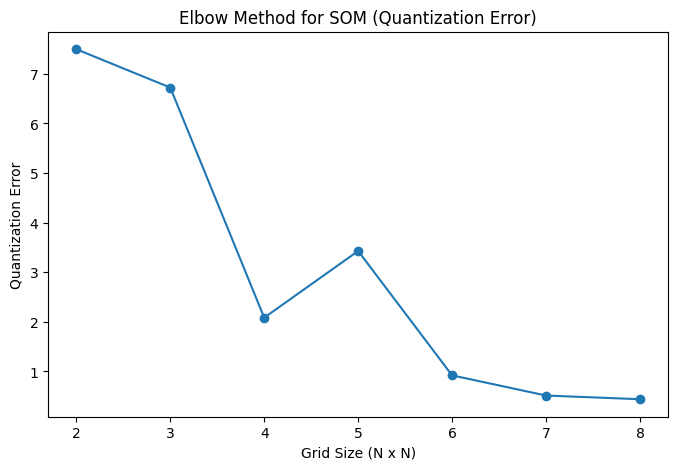

In [105]:
# Determine optimal grid size using quantization error
quantization_errors = []
grid_sizes = range(2, 9)  # Test grid sizes from 2x2 to 8x8
data_array = cleaned[['tp', 't2m']].values  # Select relevant features and convert to NumPy array

for size in grid_sizes:
    som = MiniSom(size, size, data_array.shape[1], sigma=1.0, learning_rate=0.5)
    som.random_weights_init(data_array)
    som.train_random(data_array, 100)  # Train for 100 iterations
    quantization_errors.append(calculate_quantization_error(som, data_array))

plt.figure(figsize=(8, 5))
plt.plot(grid_sizes, quantization_errors, marker='o')
plt.title('Elbow Method for SOM (Quantization Error)')
plt.xlabel('Grid Size (N x N)')
plt.ylabel('Quantization Error')
plt.show()

In [107]:
# Fit SOM with optimal grid size (e.g., 5x5)
som_grid_size = 5
som = MiniSom(som_grid_size, som_grid_size, data_array.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(data_array)
som.train_random(data_array, 100)
som_clusters = np.array([som.winner(x)[0] * som_grid_size + som.winner(x)[1] for x in data_array])
cleaned['SOM_Cluster'] = som_clusters

C:\Users\User\AppData\Local\Temp\ipykernel_7824\3639104390.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['SOM_Cluster'] = som_clusters


# Visualization

### Visualize KMeans on PCA-reduced dimensions

Text(0.5, 1.0, 'KMeans Clusters on PCA Dimensions')

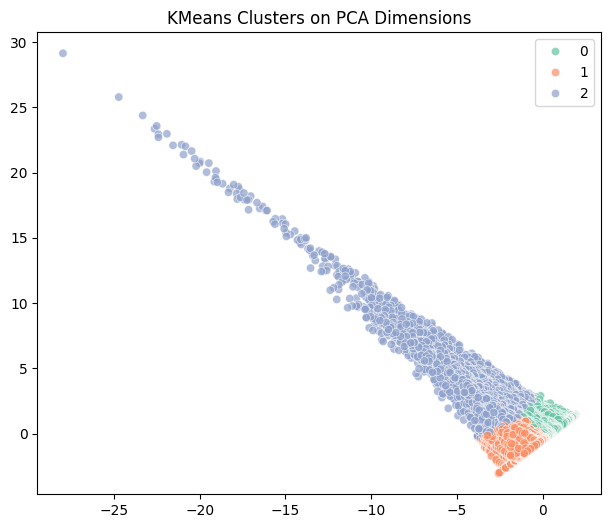

In [109]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=clusters, palette='Set2', alpha=0.7)
plt.title('KMeans Clusters on PCA Dimensions')



### Visualize SOM clusters on PCA-reduced dimensions

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


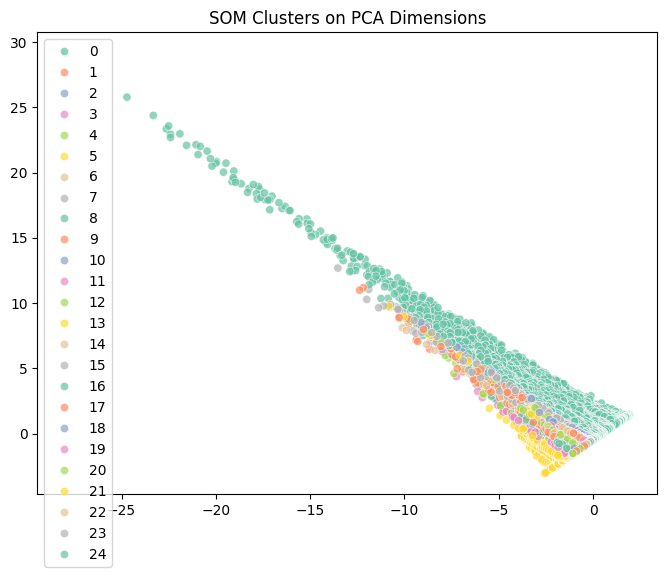

In [110]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=som_clusters, palette='Set2', alpha=0.7)
plt.title('SOM Clusters on PCA Dimensions')
plt.show()

# Evaluation

In [1]:
from sklearn.utils import resample

# Subsample 10% of the data for evaluation
sample_size = int(0.1 * len(pca_features))
sampled_data = resample(pca_features, n_samples=sample_size, random_state=42)

# Evaluate Silhouette Score on the subsampled data
silhouette_avg = silhouette_score(sampled_data, clusters[:sample_size])
silhouette_avg2 = silhouette_score(sampled_data, som_clusters[:sample_size])

print(f"Silhouette Score for K-means (Subsampled): {silhouette_avg:.2f}")
print(f"Silhouette Score for Ward (Subsampled): {silhouette_avg:.2f}")
print(f"Silhouette Score for SOM (Subsampled): {silhouette_avg2:.2f}")

Silhouette Score for K-means (Subsampled): 0.67
Silhouette Score for Ward (Subsampled): 0.65
Silhouette Score for SOM (Subsampled): 0.61
